# CS-542 Principles of Machine Learning Common Task Report
### Submitted by: Abdelazim Lokma (U79185569)

In [2]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import LSTM,Dense ,Dropout, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from keras.metrics import MeanAbsoluteError
import requests
from datetime import datetime, timedelta
import pandas as pd
from retry_requests import retry
import pandas as pd
import requests_cache
import numpy as np
import json
from openmeteo_requests import Client
import matplotlib.pyplot as plt


## Introduction

In this common task, we are assigned the task of predicting the maximum temperature for a collection of cities. This is to be done using Machine Learning techniques that we have learned in class. The goal of making these predictions is to leverage our Machine Learning skills to make money off of an event based trading platform known as *Kalshi*, which operates much like a normal trading platform, except it trades on the occurance of events rather than stock prices. 

To do this, I have decided to implement two different models of varying complexity in order to learn which model is most capable of analyzing historical weather data from the past, in order to accurately predict the max temperature in the future. 

Before delving into the model specifics, let's first examine our data sources and conduct a preliminary Exploratory Data Analysis (EDA). This initial step will enhance our understanding of the data we're working with.

In [9]:
#this variable aids in dynamicaly getting the weather data up to yesterday
yesterday = datetime.now() - timedelta(days=1)
yesterday_date_only = yesterday.date()
date_only = yesterday.date()


In [10]:
# a dictionairy storing the coordinates of each of our target cities
city_dict = {
    "miami": {
        "latitude": 25.7743,
     			"longitude": -80.1937
    },
    "austin": {
        "latitude": 30.2672,
     			"longitude": -97.7431
    },
    "chicago": {
        "latitude": 41.85,
     			"longitude": -87.65
    },
    "nyc": {
        "latitude": 40.7143,
     			"longitude": -74.006
    },
}


### Source # 1 - Open Mateo:

This source is both free and provides a vast amount of data that can be easily queried. The one downside to this API is that updates to their database arrive slowly, so data on the most recent days is either sparse or totally missing. This requires me to use other APIs in order to fill in these missing values, so that I can make my prediction for tommorows weather. 

In [11]:
def open_mateo_api_call(city):
    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = Client(session=retry_session)

    # Make sure all required weather variables are listed here
    # The order of variables in hourly or daily is important to assign them correctly below
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": city_dict[city]["latitude"],
        "longitude": city_dict[city]["longitude"],
        "start_date": "2015-01-01",
        "end_date": str(yesterday_date_only),
        "daily": [
            "temperature_2m_max", "temperature_2m_min", "daylight_duration",
            "sunshine_duration", "rain_sum", "snowfall_sum", "wind_speed_10m_max"
        ],
        "temperature_unit": "fahrenheit",
        "timezone": "America/New_York"
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]

    # Process daily data. The order of variables needs to be the same as requested.
    daily = response.Daily()

    daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
    daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()
    daily_daylight_duration = daily.Variables(2).ValuesAsNumpy()
    daily_sunshine_duration = daily.Variables(3).ValuesAsNumpy()
    daily_rain_sum = daily.Variables(4).ValuesAsNumpy()
    daily_snowfall_sum = daily.Variables(5).ValuesAsNumpy()
    daily_wind_speed_10m_max = daily.Variables(6).ValuesAsNumpy()

    daily_data = {"date": pd.date_range(
        start=pd.to_datetime(daily.Time(), unit="s", utc=True),
        end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=daily.Interval()),
        inclusive="left"
    )}

    daily_data["tmax"] = daily_temperature_2m_max
    daily_data["tmin"] = daily_temperature_2m_min
    daily_data["daylight_duration"] = daily_daylight_duration
    daily_data["sunshine_duration"] = daily_sunshine_duration
    daily_data["rain_sum"] = daily_rain_sum
    daily_data["snowfall_sum"] = daily_snowfall_sum
    daily_data["wind_speed_max"] = daily_wind_speed_10m_max

    daily_dataframe = pd.DataFrame(data=daily_data)
    daily_dataframe['date'] = pd.to_datetime(daily_dataframe['date']).dt.date
    daily_dataframe.set_index('date', inplace=True)
    daily_dataframe = daily_dataframe.rename(
        columns={'t_max': 'tmax', 't_min': 'tmin'})
    return daily_dataframe


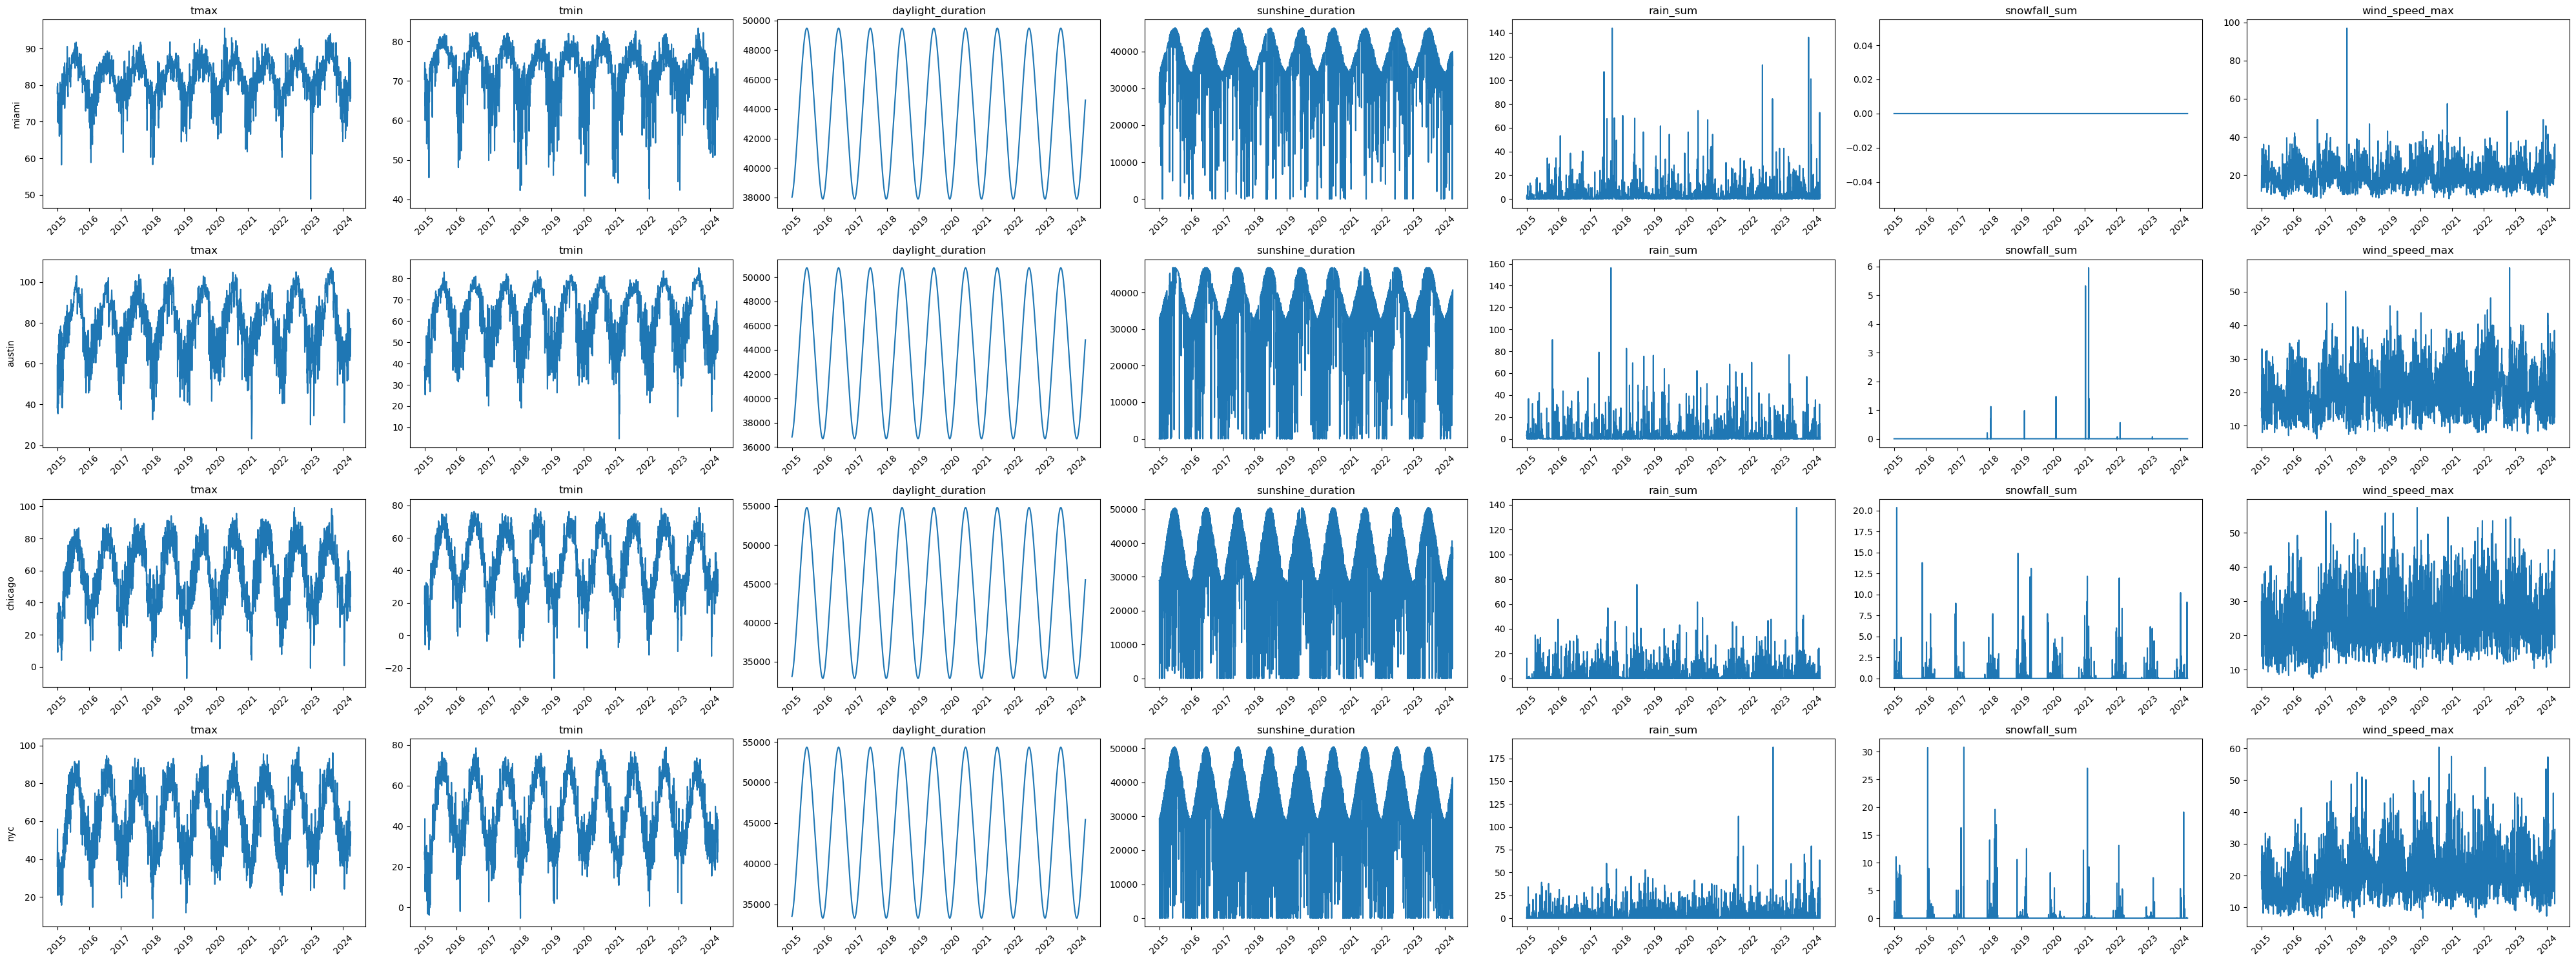

In [12]:
from matplotlib import pyplot as plt

df_miami = open_mateo_api_call('miami')
df_austin = open_mateo_api_call('austin')
df_chicago = open_mateo_api_call('chicago')
df_nyc = open_mateo_api_call('nyc')

city_names = ['miami', 'austin', 'chicago', 'nyc']
data = [df_miami, df_austin, df_chicago, df_nyc]


columns = data[0].columns

fig, axs = plt.subplots(len(data), len(columns), figsize=(40, 15))

if len(data) == 1 or len(columns) == 1:
    axs = axs.reshape(1, -1)

for i, df in enumerate(data):
    for j, col in enumerate(columns):
        axs[i, j].plot(df.index, df[col])
        axs[i, j].set_title(col)
        if j == 0:
            axs[i, j].set_ylabel(city_names[i])


        plt.setp(axs[i, j].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()


In the cell above, we see the data plotted for our Open Mateo API Data, each column is plotted separately in its own graph, and each row in the image above shows the columns for each of our four cities. We can see that the data follows a mainly cyclical nature, with values increasing and decreasing periodically. This shows us that almost all of our features vary with the season. However, some outliers exist, both Miami and austin see very little to no snow fall, which ofcourse, is to be expected. Also worth noting is the severe noise in wind speed, even though it does seem to follow a trend. On the other hand, we can see that the daylight duration follows a perfect sin wave, making it an excellent feature to use. 

### Source # 2 - MeteoStat: 

This API is also an excellent source for free historical weather Data, going back decades into the past. As it turns out, getting access to free APIs, capable of collecting historical weather data that spans more than just a few years is extremely diffuclt. So this API is essential in expending the feature set that I plan on training my LSTM model on. 

In [13]:
from meteostat import Stations, Daily, Point


def meteostat_api_call(city):
    year = yesterday.year
    month = yesterday.month
    day = yesterday.day

    # get the city location as a point object
    city_location = Point(
        city_dict[city]["latitude"], city_dict[city]["longitude"])

    start = datetime(2015, 1, 1)
    end = datetime(year, month, day)

    data = Daily(city_location, start, end)
    data = data.fetch()


    # drop columns where the count of NaNs is greater than 5% of the total length
    threshold = len(data) * 0.95
    data_cleaned = data.dropna(axis=1, thresh=threshold)
   
    return data_cleaned
 


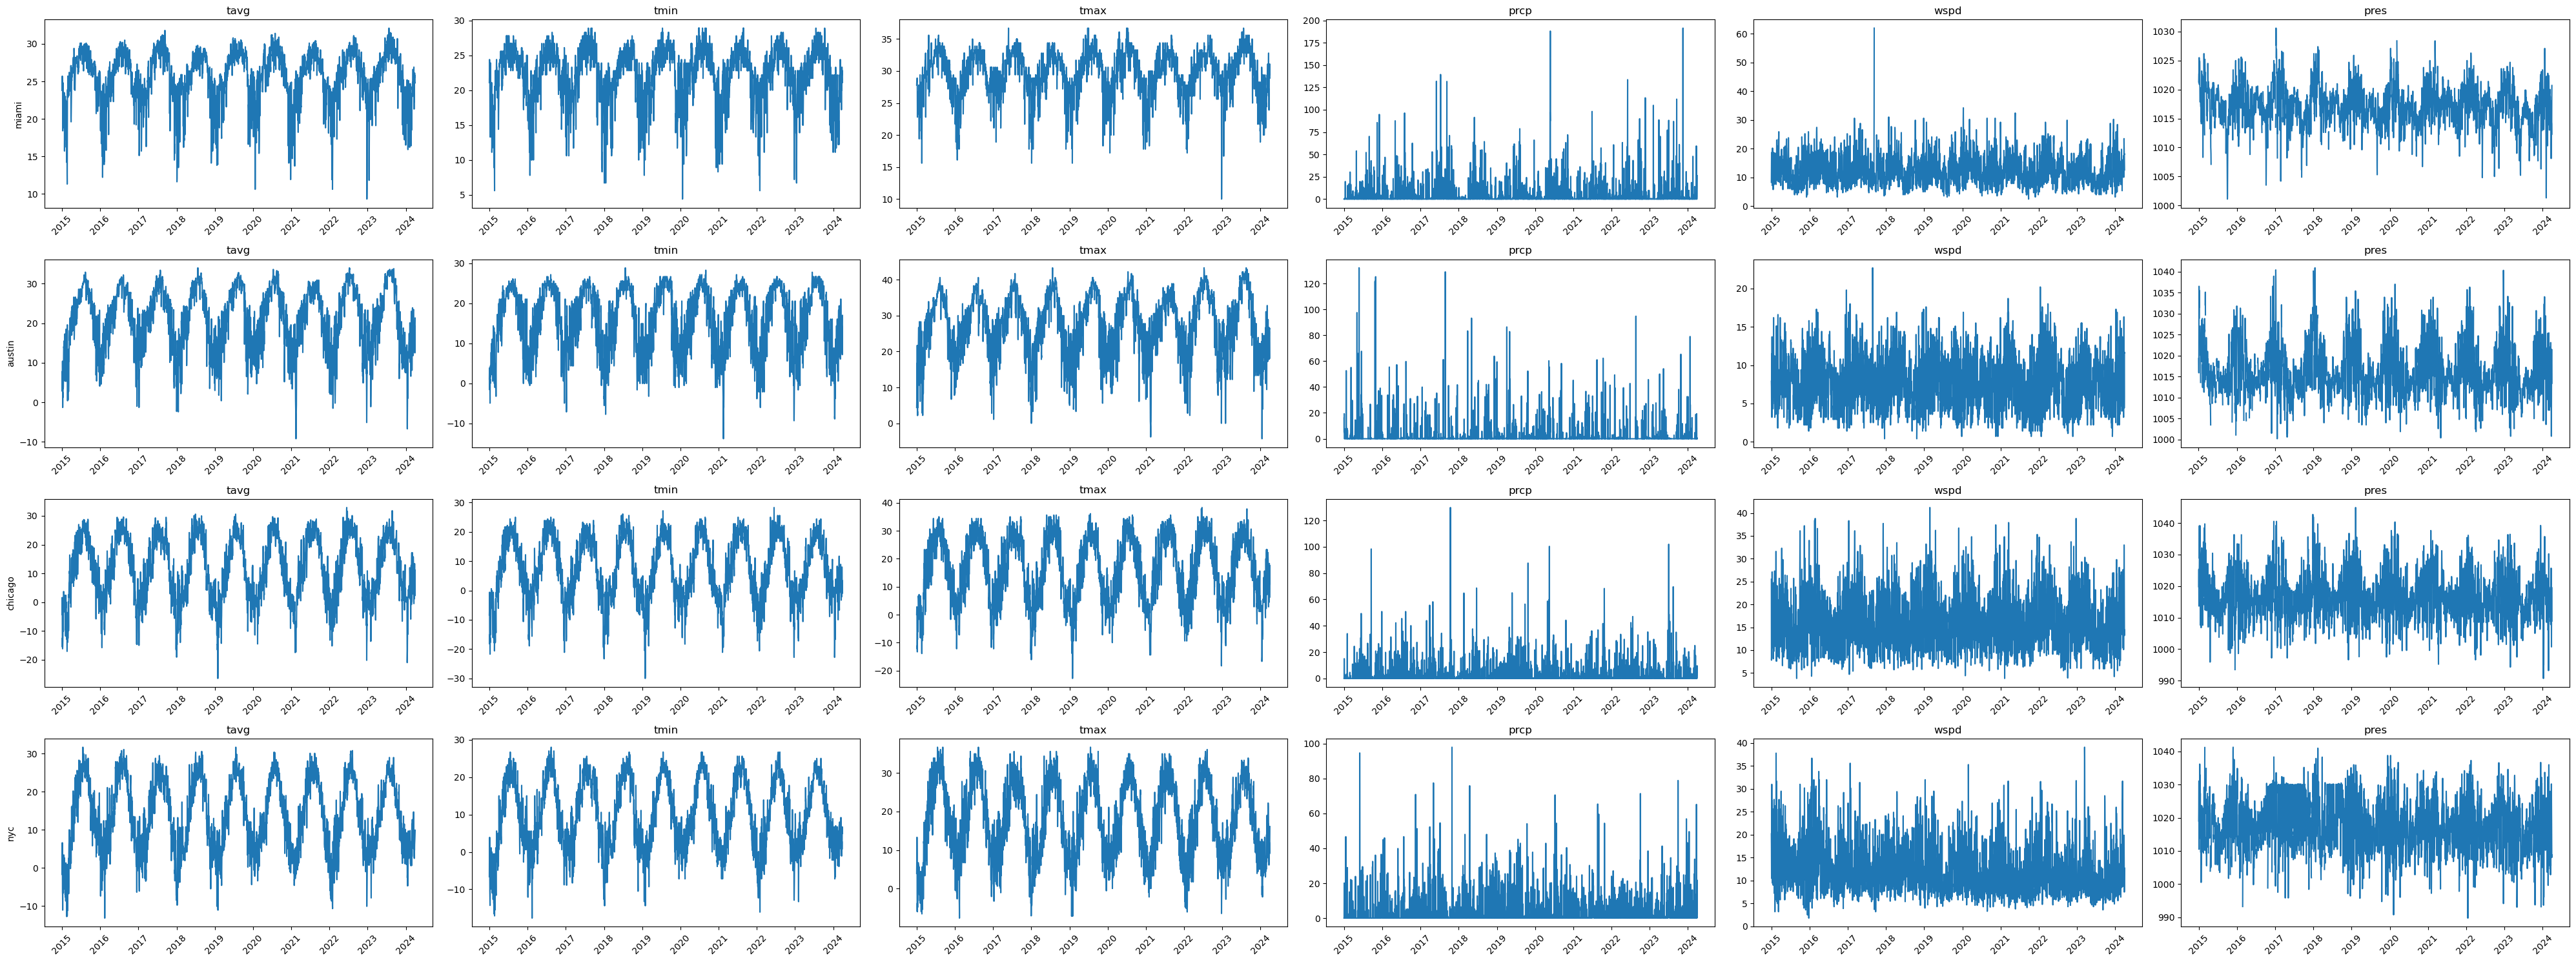

In [14]:
df_miami = meteostat_api_call('miami')
df_austin = meteostat_api_call('austin')
df_chicago = meteostat_api_call('chicago')
df_nyc = meteostat_api_call('nyc')

city_names = ['miami', 'austin', 'chicago', 'nyc']
data = [df_miami, df_austin, df_chicago, df_nyc]


columns = data[0].columns

fig, axs = plt.subplots(len(data), len(columns), figsize=(40, 15))

if len(data) == 1 or len(columns) == 1:
    axs = axs.reshape(1, -1)

for i, df in enumerate(data):
    for j, col in enumerate(columns):
        axs[i, j].plot(df.index, df[col])
        axs[i, j].set_title(col)
        if j == 0:
            axs[i, j].set_ylabel(city_names[i])

        plt.setp(axs[i, j].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()


This API shares many features that were also provided by the previous API, however, it does provide us some new features that may aid our model in its predictions. the TAVG column shows a nice cyclical pattern. Wind speed and pressure have alot of noise, but still seem to follow a cyclical trend.

### Source 3 - WeatherBit:
This source only allows me to query weather forecasts for the future. While this will not be usefull in training my model (due to the extremely limited amount of queries I am allowed to make per day), it will allow me insight into how far off my model's predictions are when compared to actual weather forecasts. 

In [15]:
import requests
from datetime import datetime, timedelta


def weartherbit_api_call(city):
    tomorrow = datetime.now() + timedelta(days=1)
    tomorrow_str = tomorrow.strftime('%Y-%m-%d')
    units = 'I'
    lang = 'en'
    api_key = "f44b4fae0c154481a1178e60a95f0038"
    base_url = "https://api.weatherbit.io/v2.0/forecast/daily"
    request_url = f"{base_url}?city={city}&key={api_key}&units={units}&lang={lang}&days=2"

    response = requests.get(request_url)
    if response.status_code == 200:
        # Parse the JSON response
        data = response.json()
        # Extract and return tomorrow's forecast data
        for forecast in data.get('data', []):
            if forecast['valid_date'] == tomorrow_str:
                return forecast
        return {"message": "Tomorrow's forecast data not found."}
    else:
        return {"error": response.json().get("error", "An error occurred.")}



### Source 4 - NOAA:

This is a manually downloaded CSV for Miami, which was used to train my initial model. I will not be using this source for my final model predictions, due to the difficulty of updating the CSV on a daily basis. I chose to do this in order to get quick results for my initial model without having to integrate automated api calls, this was done to quickly determine the viabilty of my first model, and whether I should continue working on it, or move on to a more complex one.

In [16]:
df = pd.read_csv('miami.csv')
df

,STATION,NAME,DATE,AWND,FMTM,PGTM,PRCP,PSUN,SNOW,SNWD,...,WT04,WT05,WT07,WT08,WT09,WT10,WT11,WT13,WT14,WT16
0,USW00012839,"MIAMI INTERNATIONAL AIRPORT, FL US",2007-09-25,6.49,1521.0,1520.0,1.25,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0
1,USW00012839,"MIAMI INTERNATIONAL AIRPORT, FL US",2007-09-26,4.70,1129.0,407.0,0.79,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0
2,USW00012839,"MIAMI INTERNATIONAL AIRPORT, FL US",2007-09-27,5.14,1347.0,1350.0,0.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USW00012839,"MIAMI INTERNATIONAL AIRPORT, FL US",2007-09-28,5.82,1740.0,1757.0,0.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USW00012839,"MIAMI INTERNATIONAL AIRPORT, FL US",2007-09-29,8.05,1600.0,1559.0,0.13,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6000,USW00012839,"MIAMI INTERNATIONAL AIRPORT, FL US",2024-02-28,NaN,NaN,NaN,0.00,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6001,USW00012839,"MIAMI INTERNATIONAL AIRPORT, FL US",2024-02-29,NaN,NaN,NaN,0.00,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6002,USW00012839,"MIAMI INTERNATIONAL AIRPORT, FL US",2024-03-01,NaN,NaN,NaN,0.00,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6003,USW00012839,"MIAMI INTERNATIONAL AIRPORT, FL US",2024-03-02,NaN,NaN,NaN,0.00,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Source # 5 - Visual Crossing:

This API only allows for the retrieval of 1000 records of data per day with their basic plan, so I aim to use it to just fill in any missing data that the other APIs could not provide. If there is data that other sources do not provide, it may be worth adding those columns to my dataframe, even if they are sparse. This may marginally improve model performance. 

In [17]:
#since only 1000 rows can be queried per day, we can fetch 250 rows to use per city
days_ago_250 = datetime.now() - timedelta(days=250)
days_ago_250 = days_ago_250.date()


In [18]:
import requests
import pandas as pd
import requests_cache


def visual_crossing_api_call(city):
    
    start_date = "2023-07-22"  
    end_date = str(days_ago_250)
    #end_date = "2024-03-27"  
    api_key = "WW8EF4FGUD4A9Z4NS7XRFRNGN"  
    base_url = "https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/"
    url = f"{base_url}{city}/{start_date}/{end_date}?unitGroup=us&key={api_key}&include=days"

    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for HTTP errors

        weather_data = response.json()

        if 'days' in weather_data:
            df = pd.DataFrame(weather_data['days'])

            # Columns to keep
            columns_to_keep = ['datetime',
                'feelslikemax', 'feelslikemin', 'dew', 'humidity', 'precip',
                'precipprob', 'precipcover', 'windgust', 'windspeed', 'winddir',
                'pressure', 'cloudcover', 'visibility', 'solarradiation',
                'solarenergy', 'uvindex', 'severerisk'
            ]

            df = df[columns_to_keep]
            df.set_index('datetime', inplace=True)
            df.index.name = 'date'
            
            return df
        else:
            return pd.DataFrame()  # Return an empty DataFrame if 'days' data is not found

    except requests.HTTPError as e:
        print(f"HTTP Error: {e.response.status_code} {e.response.reason}")
    except requests.RequestException as e:
        print(f"Request failed: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")





Based on the APIs shown above, I believe at this point that I have enough data to begin designing my model. Even though Visual Crossing and WeatherBit don't provide enough data to be used for model training, I may still end up using them to fill in any miss in data, or to compare my model predictions with actual weather forecasts. 

### Model 1 - LSTM Model:

Originally, my goal was to train an LSTM on my data in order to leverage its ability to process time series data. I tried mutliple LSTM architectures, and tested each of them with different hyper-parameters for just the city of Miami, before choosing the best performing model for training on the remaining cities. 

In [43]:
#these methods were added to:


#fill in any missing data that may have not been provided, using an rolling avg (with a window of 5 days)
def apply_rolling_avg(df, rolling_avg):
    for column in df.columns:
        df[column] = np.where(np.isnan(df[column]),
                              rolling_avg[column], df[column])


#data I downloaded from one of the APIs came in Celsius, we obviously need the data in farenheit
def convert_celsius_to_fahrenheit(df):
    for col in ['tmax', 'tmin']:
        if col in df.columns:
            # Convert Celsius to Fahrenheit
            df[col] = df[col].apply(lambda x: (x * 9/5) + 32)
        else:
            print(f"Column {col} does not exist in the DataFrame")
    return df


In [42]:
#This method was created to merge the data collected from both APIs
#   the goal is to keep any unique features that either APIs provide
#   but, for duplicate columns that exist in both API dataframes, we want to keep
#   the column that provides us with the most data (the column that is more dense)

def merge_dfs_keep_least_nans(df1, df2):
    merged_df = pd.merge(df1, df2, left_index=True, right_index=True,
                         how='outer', suffixes=('_left', '_right'))

    for column in df1.columns:
        if column in df2.columns:
            nan_count_left = merged_df[column + '_left'].isna().sum()
            nan_count_right = merged_df[column + '_right'].isna().sum()

            if nan_count_left <= nan_count_right:
                merged_df.drop(column + '_right', axis=1, inplace=True)
                merged_df.rename(
                    columns={column + '_left': column}, inplace=True)
            else:
                merged_df.drop(column + '_left', axis=1, inplace=True)
                merged_df.rename(
                    columns={column + '_right': column}, inplace=True)
        else:
            merged_df.rename(columns={column + '_left': column}, inplace=True)

    for column in df2.columns:
        if column not in df1.columns:
            merged_df.rename(columns={column + '_right': column}, inplace=True)

    merged_df = merged_df.loc[:, ~merged_df.columns.str.contains(
        '_left|_right$', regex=True)]
    merged_df = convert_celsius_to_fahrenheit(merged_df)
    return merged_df


In [44]:
#This section of code is designed to get the dataframes from each API call
#and then merge them using the function described above, afterwhich,
#we add the merged dfs to a dictionairy containing the city names as keys 
dfs_api_1 = []
dfs_api_2 = []
for city in city_dict:
    dfs_api_1.append(open_mateo_api_call(city))
    dfs_api_2.append(meteostat_api_call(city))


combined_dfs_dict = {}
for city, dfs in zip(city_names, zip(dfs_api_1, dfs_api_2)):
    combined_dfs_dict[city] = merge_dfs_keep_least_nans(dfs[0], dfs[1])


In [122]:
#This function creates our training / testing set 

# I used 2019 as the start date for the testing data,
# giving me around 4 years for testing and training purposes.
# I also used a look back of 3 days to make a prediction for one day in the future,
# as that is our goal.
def create_test_train_split(df):
    # Define your split dates
    split_date_start = pd.Timestamp('2019-01-01')

    train = df.loc[df.index < split_date_start]
    test = df.loc[df.index >= split_date_start]

    train_labels = train[['tmax']]
    train_features = train.drop(['tmax'], axis=1)

    test_labels = test[['tmax']]
    test_features = test.drop(['tmax'], axis=1)

    n_features = train_features.shape[1]

    n_past = 3  # Number of past days you want to use to predict the future
    n_future = 1  # Number of days you want to predict into the future

    x_train, y_train = [], []
    for i in range(n_past, len(train_features) - n_future + 1):
        x_train.append(train_features.iloc[i - n_past:i, :].values)
        y_train.append(train_labels.iloc[i:i + n_future, 0].values)

    x_train, y_train = np.array(x_train), np.array(y_train)

    x_train = np.reshape(
        x_train, (x_train.shape[0], x_train.shape[1], n_features))

    x_test, y_test = [], []
    for i in range(n_past, len(test_features) - n_future + 1):
        x_test.append(test_features.iloc[i - n_past:i, :].values)
        y_test.append(test_labels.iloc[i:i + n_future, 0].values)

    return x_train, y_train, x_test, y_test, n_features


The LSTM model below uses a bidirectional layer followed by three LSTM layers and two dense layers after that. A dropout rate of 0.3 is used after each LSTM and before the final dense layer to reduce overfitting. I was inspired by models implemented by many tutorials for using LSTMs to predict the weather. But I also used different LSTM architectures with varying complexities. The model you see below is the most complex of them, as it performed the best out of all 3 designs. 

In [123]:
class WeatherPredictor:
    def __init__(self, n_past, n_features, n_future, city_name):
        self.n_past = n_past
        self.n_features = n_features
        self.n_future = n_future
        self.city_name = city_name
        self.model = self.build_model()
        

    def build_model(self):
        model = Sequential()
        model.add(Bidirectional(
            LSTM(units=50, return_sequences=True, input_shape=(self.n_past, self.n_features))))
        model.add(Dropout(0.3))
        model.add(LSTM(units=50, return_sequences=True))
        model.add(LSTM(units=50, return_sequences=True))
        model.add(Dropout(0.3))
        model.add(LSTM(units=50, return_sequences=False))
        model.add(Dense(units=50, activation='relu'))
        model.add(Dense(units=self.n_future, activation='linear'))
        return model

    def compile_and_fit(self, x_train, y_train, epochs=200, batch_size=32):
        adam_optimizer = Adam(learning_rate=0.01)

        self.model.compile(optimizer=adam_optimizer,
                           loss='mean_squared_error', metrics=['mae'])
        self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)

    def predict(self, x_input):
            predictions = self.model.predict(x_input)
            return predictions


In [124]:
#methods to train/test the model
def train_model(predictor, x_train, y_train, epochs=200, batch_size=32):
    predictor.compile_and_fit(
        x_train, y_train, epochs=epochs, batch_size=batch_size)
    print("Training complete.")


def test_model(predictor, x_test, y_test):
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    predictions = predictor.predict(x_test)

    mae = np.mean(np.abs(predictions - y_test))
    return mae


In [4]:
#method to get the latest prediction (for tomorrow's max temp)
def predict_tomorrow_temperature(weather_predictor, x_test):
    x_test_np = np.array(x_test)

    most_recent_sequence = x_test_np[-1:].reshape(
        1, weather_predictor.n_past, weather_predictor.n_features)

    predicted_temperature = weather_predictor.predict(most_recent_sequence)

    return predicted_temperature.flatten()[0]  


### LSTM Model architecture description:

As previously stated, I tried out three different LSTM model configurations for my LSTM model on the florida NOAA dataset. 

The first model I attempted to use was the simplest model of them all. In the simpler version, there are only 3 layers: an LSTM layer, a Dropout layer, and a Dense layer. That model performed the worst, requiring me to train it for 800 epochs in order to achieve a low test MAE. 

This was an indicator that I needed to increase the complexity of the model, for for my second model version I implmented a model structure that includes a single LSTM layer for sequence processing, followed by a Dropout layer for regularization, and two Dense layers for output processing. This model perfomed slightly better, but I wanted to see if a better performance could be achieved with an even more complex model.

In the current version the LSTM model (which is the most conplex one), there are 10 layers: a Bidirectional LSTM layer, three Dropout layers interleaved with three LSTM layers, another Dropout layer followed by a Dense layer with relu activation for additional processing, and finally the output Dense layer. This model has the best perforamnce, as shown below:

In [93]:
# Creating DataFrames from the provided data
simpler_model_data = {
    "Epochs": [200, 400, 800],
    "Days": [365, 365, 365],
    "MAE": [28.44796605454278, 14.819403727030016, 5.1520691901138145]
}

medium_model_data = {
    "Epochs": [200, 300, 200, 100, 200, 200],
    "Days": [60, 365, 365, 365, 120, 30],
    "MAE": [4.867686891064201, 4.842716767615879, 4.836884901695645, 7.825567206156623, 4.847764673921251, 4.856123285195262]
}

more_complex_model_data = {
    "Epochs": [100, 200, 120, 150, 200],
    "Days": [365, 365, 365, 365, 60],
    "MAE": [4.1628882166851, 5.304998374847044, 4.05804884577372, 5.55777639366058, 4.91264012348221]
}

simple_model_df = pd.DataFrame(simpler_model_data)
medium_model_df = pd.DataFrame(medium_model_data)
more_complex_model_df = pd.DataFrame(more_complex_model_data)

# Highlighting the lowest MAE for each model
simpler_model_min_mae = simple_model_df['MAE'].min()
medium_model_min_mae = medium_model_df['MAE'].min()
more_complex_model_min_mae = more_complex_model_df['MAE'].min()

# Displaying the dataframes with highlighted lowest MAE
print("Simpler Model (Lowest MAE highlighted):")
display(simple_model_df.style.apply(lambda x: [
        "background: lightgreen" if v == simpler_model_min_mae else "" for v in x], axis=1))

print("\Medium Complexity Model (Lowest MAE highlighted):")
display(medium_model_df.style.apply(lambda x: [
        "background: lightgreen" if v == medium_model_min_mae else "" for v in x], axis=1))

print("\nMore Complex (CURRENT) Model (Lowest MAE highlighted):")
display(more_complex_model_df.style.apply(lambda x: [
        "background: lightgreen" if v == more_complex_model_min_mae else "" for v in x], axis=1))


Simpler Model (Lowest MAE highlighted):


,Epochs,Days,MAE
0,200,365,28.447966
1,400,365,14.819404
2,800,365,5.152069


\Medium Complexity Model (Lowest MAE highlighted):


,Epochs,Days,MAE
0,200,60,4.867687
1,300,365,4.842717
2,200,365,4.836885
3,100,365,7.825567
4,200,120,4.847765
5,200,30,4.856123



More Complex (CURRENT) Model (Lowest MAE highlighted):


,Epochs,Days,MAE
0,100,365,4.162888
1,200,365,5.304998
2,120,365,4.058049
3,150,365,5.557776
4,200,60,4.912640


### LSTM Model Result Analysis:

I logged my data manually as I ran my tests. The goal was to determine which configuration best equips the model for accurate max temperature prediction. Originally, most of my models trained on extremely long sequences, as I was under the impression that the LSTM would be able to handle learning patterns over large periods of time. However, this severely impacted the training time of my model, often taking 30+ minutes to train every model. 

My final attemps using short sequences (3 days) gave similar performance, with the added benefit of a much faster training time. I believe that the model performed well in both extremely long and short sequences due to the fact that, when using a sequence of 365 days, the model is able to capture the full seasonal patterns of an entire year, usefull for understanding how temperatures can fluctuate with the seaons.

With Extremely short token lengths, the model instead focuses on learning the patterns of the previous days, which are obviosuly highly relevant for predicting the next day's weather. 



## Training & Testing City Models:

Below, you will find the code where I preform the final data pre-processing and model training for each city. As well as testing the trained models. 

The only pre-processing needed was to fill in any NaN values in the model (which typically came from certain feature columns that are updated on an irregular basis). To do this, I used a rolling average with a window of 5 days.

### Miami Dataset & Model:

In [125]:
#Fill in any missing data with a rolling avg 
rolling_avg = combined_dfs_dict['miami'].rolling(window=5, min_periods=1).mean()

apply_rolling_avg(combined_dfs_dict['miami'], rolling_avg)

#split dataset
x_train_miami, y_train_miami, x_test_miami, y_test_miami, n_features = create_test_train_split(
    combined_dfs_dict['miami'])

In [126]:
miami_predictor = WeatherPredictor(3, n_features, 1,  'miami')

#trained for 250 epochs, batch size of 8 for increased variation in the training data 
train_model(miami_predictor, x_train_miami, y_train_miami, epochs = 100, batch_size=8)

Epoch 1/100


183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1583.7566 - mae: 26.4185
Epoch 2/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 37.2654 - mae: 4.8370
Epoch 3/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 40.0330 - mae: 4.9934
Epoch 4/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 38.1800 - mae: 4.8688
Epoch 5/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 39.7643 - mae: 5.0077
Epoch 6/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 39.3361 - mae: 4.9512
Epoch 7/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 42.3049 - mae: 5.2274
Epoch 8/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 38.7843 - mae: 4.9548
Epoch 9/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 44.0143 - mae: 5.2745
Epoch 10/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 42.0770 - mae: 5.0667
Epoch 11/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 37.5322 - mae: 4.8666
Epoch 12/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 39.7791 - mae: 4.9071
Epoch 13/1

The Final model uses a short token length of 3 days, and trains for 350 epochs at a batch size of 8. While this has decreased accuracy in terms of the mean abs error, the increased training speed was highly beneficial for the purposes of this project.

In [128]:
mae = test_model(miami_predictor, x_test_miami, y_test_miami)
print(mae)

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
5.100208586928611


Results of the Miami model are not too promising, having a mean absolute error of 5 degrees farenheit.

### Chicago Dataset & Model:

In [94]:
#Chicago model

rolling_avg = combined_dfs_dict['chicago'].rolling(
    window=5, min_periods=1).mean()

apply_rolling_avg(combined_dfs_dict['chicago'], rolling_avg)


x_train_chicago, y_train_chicago, x_test_chicago, y_test_chicago, n_features = create_test_train_split(
    combined_dfs_dict['chicago'])

chicago_predictor = WeatherPredictor(
    3, n_features, 1,  'chicago')

train_model(chicago_predictor, x_train_chicago, y_train_chicago, epochs= 400, batch_size=8)

Epoch 1/400


183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1450.0087 - mae: 30.6460
Epoch 2/400
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 591.4538 - mae: 20.0305
Epoch 3/400
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 567.0671 - mae: 19.7091
Epoch 4/400
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 571.7740 - mae: 19.9616
Epoch 5/400
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 536.8438 - mae: 19.5336
Epoch 6/400
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 545.9218 - mae: 19.5453
Epoch 7/400
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 531.6207 - mae: 19.0806
Epoch 8/400
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 604.9008 - mae: 20.4384
Epoch 9/400
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 552.0734 - mae: 19.8787
Epoch 10/400
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 565.4333 - mae: 19.7898
Epoch 11/400
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 559.3577 - mae: 19.9146
Epoch 12/400
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 554.9857 - m

In [95]:
mae = test_model(chicago_predictor, x_test_chicago, y_test_chicago)
print(mae)

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
15.253390723875038


The results of the chicago model are much worse, wheras the Miami model's performance was at an MAE of 5 degrees farenheight. 

In [101]:
rolling_avg =  combined_dfs_dict['nyc'].rolling(window=3, min_periods=1).mean()

apply_rolling_avg(combined_dfs_dict['nyc'], rolling_avg)

x_train_nyc, y_train_nyc, x_test_nyc, y_test_nyc, n_features = create_test_train_split(
    combined_dfs_dict['nyc'])

nyc_predictor = WeatherPredictor(
    3, n_features, 1,  'nyc')

train_model(nyc_predictor, x_train_nyc, y_train_nyc, epochs=300, batch_size=8)


Epoch 1/300


183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1251.1132 - mae: 27.7368
Epoch 2/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 456.3437 - mae: 18.0527
Epoch 3/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 449.7972 - mae: 17.2830
Epoch 4/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 435.1013 - mae: 17.3305
Epoch 5/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 444.6025 - mae: 17.7593
Epoch 6/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 456.5568 - mae: 17.8633
Epoch 7/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 487.7428 - mae: 18.2363
Epoch 8/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 456.3161 - mae: 17.7557
Epoch 9/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 446.4478 - mae: 17.6348
Epoch 10/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 451.9871 - mae: 17.7242
Epoch 11/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 475.1471 - mae: 17.8901
Epoch 12/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 437.8721 - m

In [102]:
mae = test_model(nyc_predictor, x_test_nyc, y_test_nyc)
print(mae)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
14.981886878085897


The NYC model performs similarly to the Chicago model, both models seem to underperform when compared to miami model

In [154]:
#austin model

rolling_avg = combined_dfs_dict['austin'].rolling(window=5, min_periods=1).mean()

apply_rolling_avg(combined_dfs_dict['austin'], rolling_avg)

x_train_austin, y_train_austin, x_test_austin, y_test_austin, n_features = create_test_train_split(
    combined_dfs_dict['austin'])


austin_predictor = WeatherPredictor(
    3, n_features, 1,  'austin')


train_model(austin_predictor, x_train_austin,
            y_train_austin, epochs=250, batch_size=16)


/var/folders/kd/knlpfg7s6rq1mm0mcrh9knw00000gn/T/ipykernel_86570/3347561606.py:5: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  train = df.loc[df.index < split_date_start]
/var/folders/kd/knlpfg7s6rq1mm0mcrh9knw00000gn/T/ipykernel_86570/3347561606.py:6: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  test = df.loc[df.index >= split_date_start]


Epoch 1/250


/Users/abdelazimlokma/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 2340.6885 - mae: 38.5842
Epoch 2/250
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 359.9778 - mae: 15.2373
Epoch 3/250
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 356.2300 - mae: 15.0833
Epoch 4/250
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 352.4089 - mae: 15.2429
Epoch 5/250
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 307.2320 - mae: 14.1327
Epoch 6/250
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 341.0131 - mae: 14.7980
Epoch 7/250
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 347.8531 - mae: 14.8722
Epoch 8/250
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 344.1033 - mae: 14.8045
Epoch 9/250
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 346.8586 - mae: 14.9418
Epoch 10/250
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 337.9450 - mae: 14.8939
Epoch 11/250
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 344.8239 - mae: 15.0190
Epoch 12/250
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 350.3725 - mae: 15.0589
Epoch 13/250

In [155]:
mae = test_model(austin_predictor, x_test_austin, y_test_austin)
print(mae)

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
10.927590507986658


For the Austin model, we can see that the MAE is lower than the NYC and Chicago models, seemingly indicating that the LSTM performs better in cities with warmer climates than colder ones. 

In [156]:
#the code below shows the function that is used for making automated weather predictions for tomorrow.
#This function is called by the kalshi API script that I have implemented in the report.ipynb notebook

def get_tomorrows_predictions_per_city():
    predictions = {"miami": 0, "nyc": 0, "austin": 0, "chicago": 0}

    # Adjust this to be a dictionary mapping city names to predictor instances
    predictors = {
        "miami": miami_predictor,
        "nyc": nyc_predictor,
        "austin": austin_predictor,
        "chicago": chicago_predictor
    }

    for city, predictor in predictors.items():
        # Construct the x_test variable name dynamically
        x_test_var_name = f"x_test_{city}"

        # Fetch the appropriate x_test variable
        if x_test_var_name in locals():
            x_test_city = locals()[x_test_var_name]
        elif x_test_var_name in globals():
            x_test_city = globals()[x_test_var_name]
        else:
            print(f"No test data found for {city}")
            continue

        # Call the prediction function
        try:
            prediction = predict_tomorrow_temperature(predictor, x_test_city)
            # Update the predictions dictionary
            predictions[city] = prediction
        except ValueError as e:
            print(f"Error predicting temperature for {city}: {e}")

    return predictions


In [157]:
get_tomorrows_predictions_per_city()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


{'miami': 81.59318, 'nyc': 59.98324, 'austin': 78.01348, 'chicago': 48.813652}

### Model 2 - Ridge Regression Model:

Due to the unsatisfactory performance of the LSTM model, I decided to try a simpler approach and use a ridge regression model instead to predict the weather. This was done on the last day of my work on this common task, so I was not able to use this model to make any predictions. However, I believe that the effort taken to try a different model to the LSTM was worth it, due to the improved results that I will be discussing below.

The backtest function below evaluates a predictive model's performance over time by iteratively training the model on a growing window of historical data and testing it on subsequent segments for each city. It also plots the model's predictions against actual values so that we can visually see the models performance across all four cities.

In [157]:
def backtest(weather, model, predictors, cityname, start=1825, step=90):
    all_predictions = []
    for i in range(start, weather.shape[0], step):
        train = weather.iloc[:i, :]
        test = weather.iloc[i:(i+step), :]

        model.fit(train[predictors], train["target"])

        preds = model.predict(test[predictors])

        combined = test.assign(prediction=preds)
        combined["diff"] = (combined["prediction"] - combined["target"]).abs()
        all_predictions.append(combined)

    all_predictions_df = pd.concat(all_predictions)

    plt.figure(figsize=(14, 7))
    plt.plot(all_predictions_df.index,
             all_predictions_df["target"], label='Actual Values', color='blue')
    plt.plot(all_predictions_df.index,
             all_predictions_df["prediction"], label='Predicted Values', color='red', linestyle='--')
    plt.title(f"Ridge Regression Model Performance Over Test Set for {cityname}")
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    return all_predictions_df


def create_target_col(df):
    df["target"] = df.shift(-1)["tmax"]
    df.ffill(inplace=True) 




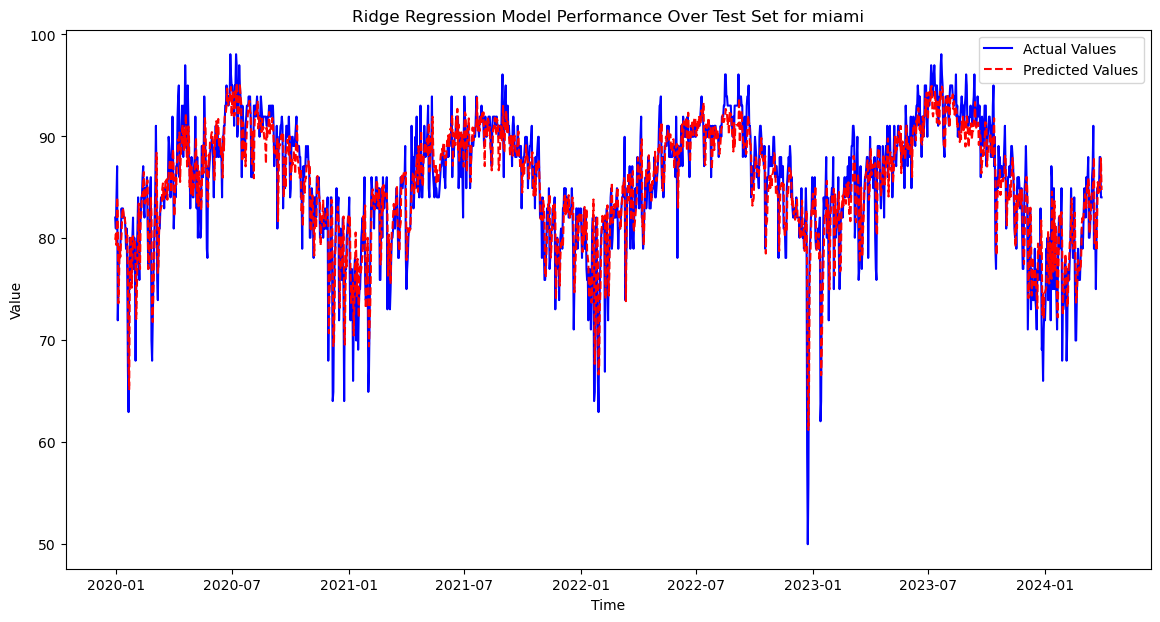

avg error for miami is 2.193070549107844


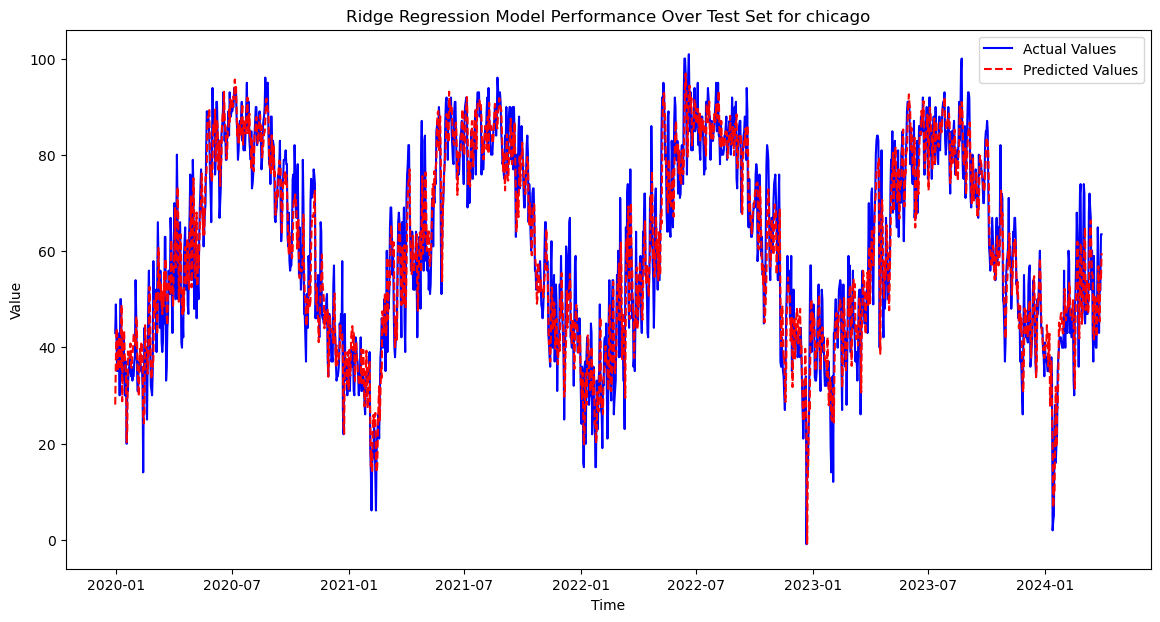

avg error for chicago is 5.640631157938787


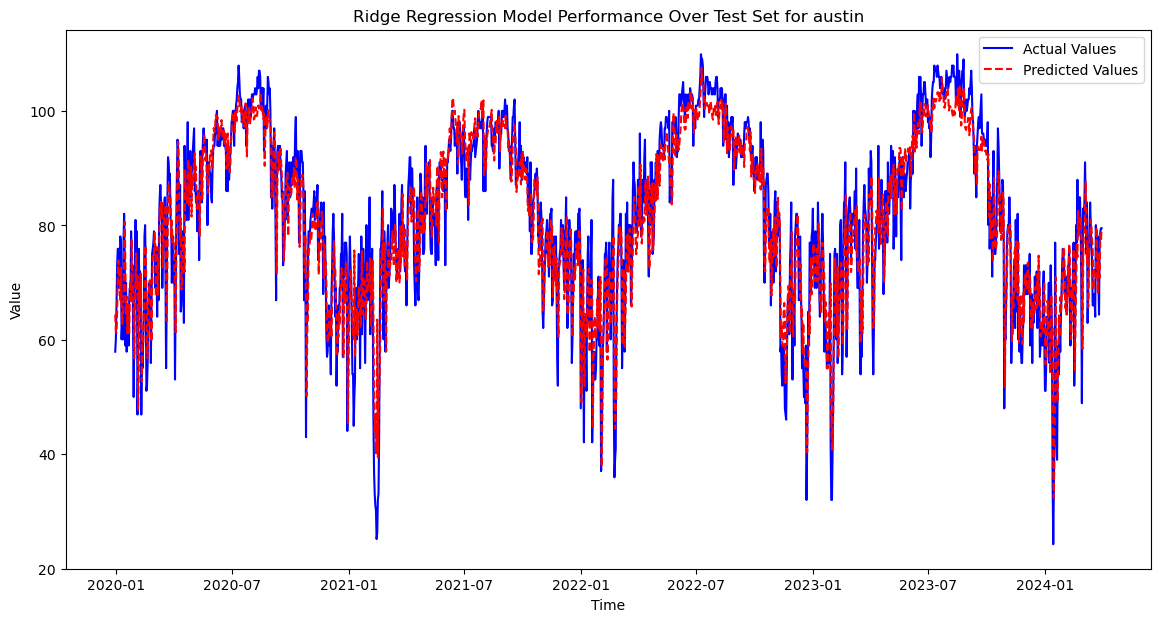

avg error for austin is 4.964151014564885


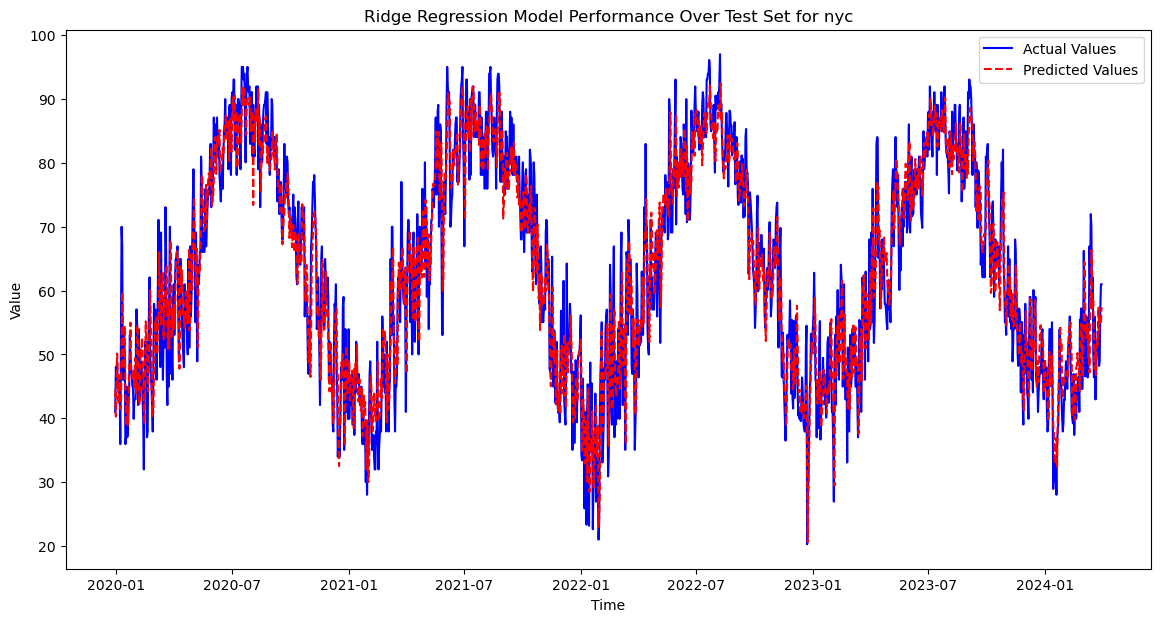

avg error for nyc is 4.883631137965153


In [158]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

for city in ["miami", "chicago", "austin", "nyc"]:
    ridge_reg = Ridge(alpha=0.1)
    city_df = combined_dfs_dict[city]
    create_target_col(city_df)
    predictors = city_df.columns[~city_df.columns.isin(["target"])]
    city_df = city_df.fillna(city_df.mean())
    predictions = backtest(city_df, ridge_reg, predictors, city)
    avg_error = mean_absolute_error(
        predictions["target"], predictions["prediction"])
    print(f"avg error for {city} is {avg_error}")


### Ridge Regression Model Results:

The ridge regression model performs significantly better than the LSTM model, achieving a best case MAE of 2.19 degrees farenheight for the city of Miami, and a worst case MAE of 5.6 for Chicago. This is a significant improvement in performance that would have been much more suitable for use in predicting Kalshi events had I had more time for event prediction. 

### Kalshi Trading Strategy and Results:

For my first week of trading, I originally just made random trades, as I was learning how to use the Kalshi trading platform.

However, for week 2 I began using my LSTM model to make predictions manually. My strategy at the time was very simple, I would just buy YES contracts for the specific market (the max temp in a city) based on the predicted max temperature of my model. Ofcourse, due to my LSTM model's poor performance, most of my trades were not profitable. 

For week 3 I implemented a strategty that aimed to hedge my trades in order to increase profit or reduce loss. Since each Event (max temp in a city) had 6 markets (max temp being x in city y), I would make YES trades on the event matching my model's predicted temperature, and NO trades on all other markets for that event. In the worse case, only two of my trades would net a loss. 

Below is the downloaded CSV from Kalshi showing my trades:


In [5]:
csv_path = 'Kalshi-Recent-Activity.csv'

orders = pd.read_csv(csv_path)
orders


,type,Settled_Time,Market_Title,Result,Profit_In_Dollars,Yes_Contracts_Owned,Yes_Contracts_Average_Price_In_Cents,No_Contracts_Owned,No_Contracts_Average_Price_In_Cents
0,Settlement,2024-03-30T12:01:06.111187Z,Will the **high temp in Miami** be >80° on Mar...,no,40.0,0,0.0,40,48.77
1,Settlement,2024-03-30T12:01:06.111187Z,Will the **high temp in Miami** be <73° on Mar...,no,10.0,0,0.0,10,99.00
2,Settlement,2024-03-30T12:01:06.111187Z,Will the **high temp in Miami** be 79-80° on M...,yes,0.0,0,0.0,40,48.77
3,Settlement,2024-03-30T12:01:06.111187Z,Will the **high temp in Miami** be 77-78° on M...,no,40.0,0,0.0,40,69.60
4,Settlement,2024-03-30T12:01:06.111187Z,Will the **high temp in Miami** be 75-76° on M...,no,2.0,0,0.0,2,50.00
5,Settlement,2024-03-30T12:01:06.111187Z,Will the **high temp in Miami** be 73-74° on M...,no,2.0,0,0.0,2,50.00
6,Settlement,2024-03-30T12:00:59.065034Z,Will the **high temp in Austin** be <74° on Ma...,no,80.0,0,0.0,80,65.92
7,Settlement,2024-03-30T12:00:59.065034Z,Will the **high temp in Austin** be 78-79° on ...,yes,0.0,0,0.0,240,77.77
8,Settlement,2024-03-30T12:00:59.065034Z,Will the **high temp in Austin** be 76-77° on ...,no,80.0,0,0.0,80,85.53
9,Settlement,2024-03-30T12:00:59.065034Z,Will the **high temp in Austin** be 74-75° on ...,no,22.0,0,0.0,22,50.00


In [4]:
# Update this to the path of your CSV file
csv_file_path = 'Kalshi_trading_log.csv'


trades = pd.read_csv(csv_file_path)
trades 





,type,Market_Title,Market_Id,Original_Date,Price_In_Cents,Amount_In_Dollars,Fee_In_Dollars,Traded_Time,Direction
0,Trade,Will the high temp in Chicago be 50-51° on Mar...,494c92da-b406-4068-bd93-b692a9a56c30,"Mar 29, 2024",99,8,0.0,"Mar 29, 2024 at 7:46PM EDT",No
1,Trade,Will the high temp in Chicago be 52-53° on Mar...,262de5e1-98ee-4ba2-8e61-3254012d6d67,"Mar 29, 2024",99,7,0.0,"Mar 29, 2024 at 6:20PM EDT",No
2,Trade,Will the **high temp in Austin** be 78-79° on ...,ff76597e-a6cc-40c6-961a-3c4ace2f1736,"Mar 29, 2024",99,40,0.0,"Mar 29, 2024 at 6:17PM EDT",No
3,Trade,Will the **high temp in Austin** be 78-79° on ...,ff76597e-a6cc-40c6-961a-3c4ace2f1736,"Mar 29, 2024",99,7,0.0,"Mar 29, 2024 at 6:17PM EDT",No
4,Trade,Will the **high temp in Austin** be 78-79° on ...,ff76597e-a6cc-40c6-961a-3c4ace2f1736,"Mar 29, 2024",99,40,0.0,"Mar 29, 2024 at 6:17PM EDT",No
...,...,...,...,...,...,...,...,...,...
335,Trade,Will the **high temp in NYC** be 49-50° on Mar...,619903f6-431d-44e1-b392-6d5cfda78630,"Mar 8, 2024",2,1,0.0,"Mar 8, 2024 at 3:15PM EST",Yes
336,Trade,Will the **high temp in NYC** be 49-50° on Mar...,619903f6-431d-44e1-b392-6d5cfda78630,"Mar 8, 2024",2,1,0.0,"Mar 8, 2024 at 3:13PM EST",Yes
337,Trade,Will the **high temp in NYC** be 49-50° on Mar...,619903f6-431d-44e1-b392-6d5cfda78630,"Mar 8, 2024",2,1,0.0,"Mar 8, 2024 at 3:11PM EST",Yes
338,Trade,Will the **high temp in NYC** be 49-50° on Mar...,619903f6-431d-44e1-b392-6d5cfda78630,"Mar 8, 2024",2,1,0.0,"Mar 8, 2024 at 3:09PM EST",Yes
